In [1]:
from diffusers import StableDiffusionPipeline, StableDiffusionInpaintPipeline
import torch
import os
import random
import requests
from io import BytesIO
import numpy as np
import subprocess
from torchvision import models, transforms
import numpy as np
import dlib
from PIL import Image, ImageFilter, ImageDraw
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import binary_closing
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

2024-02-23 17:45:28.646568: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 17:45:28.646658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 17:45:28.829441: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-23 17:45:29.178458: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-23 17:45:30.917603: W tensorflow/compiler/tf2

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

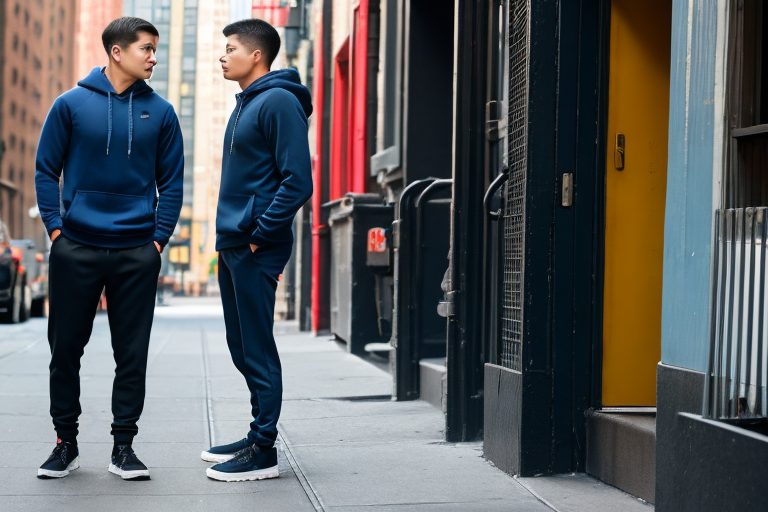

In [28]:
model_path = "ohmwWithPPL"

pipe = StableDiffusionPipeline.from_pretrained(model_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)

prompt = "side view portrait, 1man (ohmw man, wearing a black and blue suit) and 1boy (short, blonde hair, wearing a red hoodie) standing in New York City"
negative_prompt= "text, error, cropped, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature"


result = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,
    generator=torch.Generator(device).manual_seed(1),
    width=768,
    height=512,
    strength=0.7,
    guidance_scale=7,
)

image = result.images[0]
image.show()

  0%|          | 0/50 [00:00<?, ?it/s]

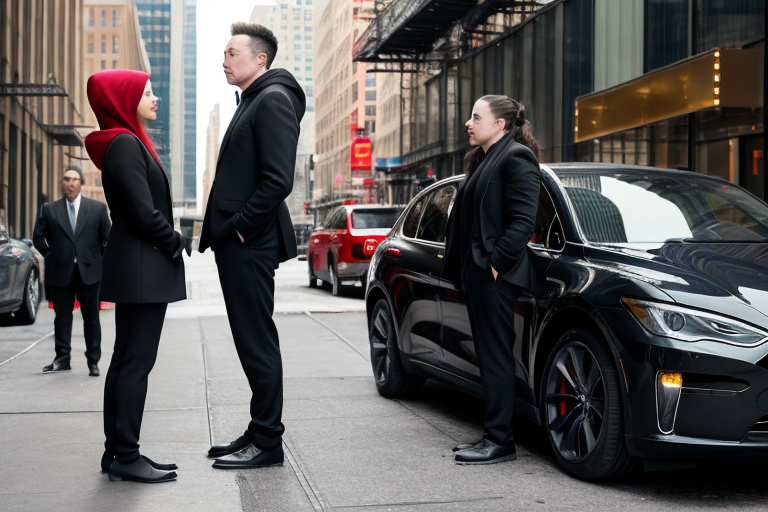

In [29]:
prompt = "side view portrait, (Adelle, wearing a black suit) and (elon musk, wearing a red hoodie)), standing in New York City"
negative_prompt= "text, error, cropped, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature"


result = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,
    generator=torch.Generator(device).manual_seed(1),
    width=768,
    height=512,
    strength=0.7,
    guidance_scale=7,
)

image = result.images[0]
image.show()

I0000 00:00:1708724920.046939     972 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1708724920.097207    4528 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.154.05), renderer: NVIDIA A10G/PCIe/SSE2


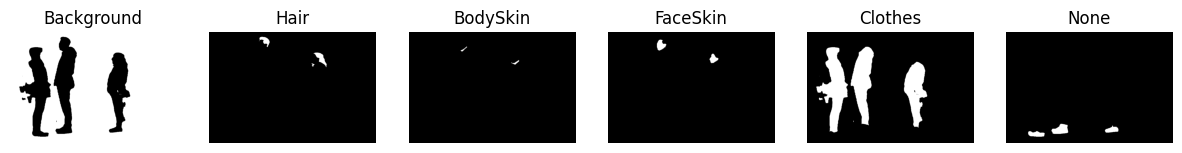

In [30]:

import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision


full_image = image
numpy_image = np.array(full_image)


if numpy_image.dtype != np.uint8:
    numpy_image = numpy_image.astype(np.uint8)
mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=numpy_image)


model_path = 'selfie_multiclass_256x256.tflite'
BaseOptions = mp.tasks.BaseOptions
ImageSegmenter = mp.tasks.vision.ImageSegmenter
ImageSegmenterOptions = mp.tasks.vision.ImageSegmenterOptions
VisionRunningMode = mp.tasks.vision.RunningMode


options = ImageSegmenterOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.IMAGE,
    output_category_mask=True
)

with ImageSegmenter.create_from_options(options) as segmenter:
    segmentation_result = segmenter.segment(mp_image)
    category_mask = segmentation_result.category_mask


    category_names = {
        0: 'Background',
        1: 'Hair',
        2: 'BodySkin',
        3: 'FaceSkin',
        4: 'Clothes',
    }
    
    category_mask_np = segmentation_result.category_mask.numpy_view()
    unique_categories = np.unique(category_mask_np)



    # SHOW
    
    plt.figure(figsize=(15, 5))
    columns = len(unique_categories)
    for i, category_id in enumerate(unique_categories):
        plt.subplot(1, columns, i+1)
        mask = category_mask_np == category_id
        plt.imshow(mask, cmap='gray')
        plt.title(f"{category_names.get(category_id)}")
        plt.axis('off')
    plt.show()